# PODSUMOWANIE ZNAJDUJE SIĘ NA KOŃCU NOTEBOOKA

# ETAP 1: POZYSKANIE DANYCH

In [10]:
%config IPCompleter.greedy=True

In [11]:
# !conda install pandas tqdm matplotlib redis-py spacy nltk -y
# !conda install -c conda-forge tweepy scikit-learn -y
# !python -m spacy download pl_core_news_md

import pandas as pd

import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

import redis
import tweepy
from sklearn.cluster import KMeans
import time


from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.metrics.pairwise import pairwise_distances_argmin
from sklearn.datasets import make_blobs
from sklearn.manifold import TSNE
import spacy
#library for regular expressions
import re    
import string
from spacy.lang.pl.examples import sentences 
from nltk.tokenize import TweetTokenizer

import os

NUM_CLUSTERS = 3

## Loading tweet IDs from file.

In [12]:
def load_tweet_ids():
    chunksize = 10 ** 6

    LINES = 332706325

    frames = []

    iter = 0
    with tqdm(total = 332706325) as pbar:
        for chunk in pd.read_csv('full_dataset_clean.tsv', chunksize=chunksize, delimiter='\t'):
            frames.append(chunk[chunk["lang"] == "pl"])
            pbar.update(len(chunk))

    result = pd.concat(frames)
    result = result.reset_index()
    
    print(result.head())
    
    result.to_csv('full_dataset_clean_pl.csv')

In [13]:
# load_tweet_ids()

## Downloading and storing in redis + file

In [3]:
def download():

    API_Key = "wih5UnfzJdrDqbDmT8s8Q1eOb"
    API_Key_Secret = "XzX24SMSa5uEuqpOuPq9kOKmEmKncifbOzERmeBgsIwf434Lq2"
    Bearer_Token = "AAAAAAAAAAAAAAAAAAAAAMSBYQEAAAAAc8cHzyylG4bieF6aiobvH7OhNAo%3DIkidGH9zpBZhEwwPQS1DxZVk2gJnVx4YYBaykWEbuS01T7066e"

    client = tweepy.Client(Bearer_Token)

    r = redis.Redis(
        host='127.0.0.1',
        port=6379, 
        password='Kr7Wygxq3y')


    for i in tqdm(range(len(result))):
        tweet_id = str(result.iloc[i].tweet_id)

        if r.get(tweet_id) is None:
            try:
                response = client.get_tweet(tweet_id)
                time.sleep(1)
            except tweepy.TooManyRequests as tmr:
                time.sleep(16 * 60)
            print(response)
            if response.errors:
                r.set(tweet_id, "")
            else:
                r.set(tweet_id, str(response.data))

def redit_to_file():
    dct = {}
    for i in r.scan_iter('*'):
        dct[i.decode('utf-8')] = r.get(i).decode('utf-8')
    print(len(dct))
    import json
    with open('redis.json', 'w', encoding='utf-8') as f:
        json.dump(dct, f)

In [4]:
import redis

r = redis.Redis(
    host='127.0.0.1',
    port=6379, 
    password='Kr7Wygxq3y')

In [5]:
redit_to_file()

90884


## Loading input from redis

In [17]:
texts = []

ctr = 0
full_ctr = 0
for i in r.scan_iter('*'):
    if r.get(i):
        text = r.get(i).decode("utf-8")
        texts.append(text)
        full_ctr += 1
    ctr += 1
    
print(f"{full_ctr}/{ctr}")

59795/77017


## Pre-processing danych
Kolejnym etapem jest wstępne przetworzenie danych, które polega na czyszczeniu, dzieleniu, zamianie na wektory.

In [18]:
data = pd.DataFrame({'text': texts}) #wybieramy część danych do dalszej obróbki

pd.options.mode.chained_assignment = None # żeby ignorować ostrzeżenie o updacie df

data.head()

,text
0,Znalezione na FB 👍Koty naturalnym lekiem na CO...
1,@sikorskiradek @AndrzejDuda @realDonaldTrump J...
2,Nowe definicje przypadków COVID-19 wg ECDC. Mu...
3,FAO przygotowała 7 zasad odżywania w czasie pa...
4,"@PSciechowski Tylko ciekawe, skąd tak silna ko..."


### Czyszczenie

##### Normalizacja
Normalizujemy tekst poprzez zmniejszenie liter na małe.

In [19]:
def normalize(df_in):
    df_in['text'] = df_in['text'].str.lower()
    return df_in

##### Usuwane URL, hashtagów

Usuwanie adresów URL, hashtagów i stylów: W naszym zbiorze danych tekstowych możemy mieć hiperłącza, hashtagi lub style, takie jak retweet z zestawu danych na Twitterze itp. Nie dostarczają one żadnych istotnych informacji i można je usunąć.

In [20]:
def cleaning_hyperlinks(tweet):

    # remove hyperlinks
    tweet = re.sub('((www.[^s]+)|(https?://[^s]+))',' ',tweet)
    
    # remove hyperlinks
    tweet = re.sub(r'@\S+', " ", tweet)
    
    # remove hashtags
    # only removing the hash # sign from the word
    tweet = re.sub(r'#', ' ', tweet)

    # remove hashtags
    # only removing the hash # sign from the word
    tweet = re.sub(r'#', ' ', tweet)

    # remove old style retweet text "RT"
    tweet = re.sub(r'^RT[\s]+', ' ', tweet)
    
    return tweet

def clean_hyperlinks(df_in):
    df_in['text'] = df_in['text'].apply(cleaning_hyperlinks)
    return df_in

##### Usuwane znaków interpunkcyjnych

Usuwamy znaki interpunkcyjne.

In [21]:
punctuations_list = string.punctuation

def cleaning_punctuations(text):
    
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)

def clean_punctuations(df_in):
    df_in['text'] = df_in['text'].apply(cleaning_punctuations)
    return df_in

##### Stopwords

Usuwamy stopwords.

In [22]:
site_package = "/home/beniamin/miniconda3/envs/zum/lib/python3.8/site-packages/pl_core_news_md/"
nlp = spacy.load(site_package + 'pl_core_news_md-2.3.0')

stopwordlist = nlp.Defaults.stop_words

def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in stopwordlist])

def clean_stopwords(df_in):
    df_in['text'] = df_in['text'].apply(cleaning_stopwords)
    return df_in

##### Powtarzające sie znaki

Usuwamy powtarzające się znaki.

In [23]:
def cleaning_repeating_char(text):
    return re.sub(r'(.)1+', r'1', text)

def clean_rpt_chars(df_in):
    df_in['text'] = df_in['text'].apply(cleaning_repeating_char)
    return df_in

##### Liczby

Usuwamy znaki numeryczne

In [24]:
def cleaning_numbers(text):
    return re.sub('[0-9]+', '', text)

def clean_numbers(df_in):
    df_in['text'] = df_in['text'].apply(cleaning_numbers)
    return df_in

##### Tokenizacja

In [25]:
# tokenizacja
tokenizer = TweetTokenizer()

def tokenize(df_in):
    df_in['text'] = df_in['text'].apply(tokenizer.tokenize)
    df_in['text'] = df_in['text'].apply(lambda x: ' '.join(x))
    return df_in

#### Ręczna obróbka danych

In [26]:
sentences = [
    "testytestytesty koronawirus covi testy testy testy saxfrrgx",
    "testytestytesty koronawirus covi testy testy testy smub",
    "icymi"
]

part_sentences = [
    ["ipptv"],
    ["globalceasefire", "covipandemic"]
]


def filter_bad_sentences(df_in):
    for sentence in sentences: 
        df_in = df_in[df_in.text != sentence]
        
    def check(text, part_stcs):
        for part_stc in part_stcs:
            if f" {part_stc} " in text:
                return False
        return True
        
    for parts in part_sentences:
        df_in = df_in[data.text.map(lambda x: check(x, parts))]
    return df_in

#### Czyszczenie wszystkiego

In [27]:
def clean_input(df_in):
    df_in = normalize(df_in)
    df_in = clean_hyperlinks(df_in)
    df_in = clean_punctuations(df_in)
    df_in = clean_stopwords(df_in)
    df_in = clean_rpt_chars(df_in)
    df_in = clean_numbers(df_in)
    df_in = tokenize(df_in)
    df_in = filter_bad_sentences(df_in)
    return df_in
data_different = pd.DataFrame({"text": list(set(data.text))})
print("From: ", data_different.shape)
clean_data = clean_input(data_different)
clean_data = clean_data[1:]
print("To: ", clean_data.shape)
clean_data = clean_data.reset_index()
data['text'].head()
clean_data['text'].head()

From:  (58458, 1)
To:  (57684, 1)


<ipython-input-26-4d2421305894>:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_in = df_in[data.text.map(lambda x: check(x, parts))]


0                                             bz sonko
1                       eeh eh muzamkwatila fire force
2    polska wyborami podało raportu spodziewając wz...
3                                  ochrona coronavirus
4    corona salute corona virus coronavirus emptyst...
Name: text, dtype: object

In [28]:
X = clean_data.text

## Zamiana na wektory z użyciem TF-IDF Vectorizer

Po podziale musimy zamienić dane tekstowe na wektory, na których będzie pracował zbudowany model.

from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectorizer.fit(X_train)
print('No. of feature_words: ', len(vectorizer.get_feature_names()))

In [29]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

cluster_vectorizer = TfidfVectorizer(ngram_range=(1,2),
                                     max_features=50,
                                     min_df=2)

X_cluster_vec = cluster_vectorizer.fit_transform(clean_data.text)
print('No. of feature_words: ', len(cluster_vectorizer.get_feature_names()))
print(X_cluster_vec.shape, type(X_cluster_vec))

train_vectorizer = CountVectorizer()
X_train_vec = train_vectorizer.fit_transform(clean_data.text)

non_zeros = np.asarray(X_train_vec.sum(axis=0))[0]
THRESHOLD = 10
X_train_vec = X_train_vec[:, non_zeros > THRESHOLD]
print(X_train_vec.shape)

No. of feature_words:  50
(57684, 50) <class 'scipy.sparse.csr.csr_matrix'>
(57684, 8323)


In [30]:
kmeans_model = KMeans(n_clusters=NUM_CLUSTERS, n_init=100,
                      random_state=6, verbose=0)
kmeans = kmeans_model.fit(X_cluster_vec)
kmeans_clusters = kmeans.predict(X_cluster_vec)
cluster_centers = kmeans.cluster_centers_

(array([ 7688.,     0.,     0.,     0.,     0.,  7854.,     0.,     0.,
            0., 42142.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

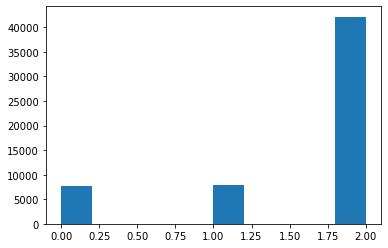

In [31]:
plt.hist(kmeans_clusters)

In [32]:
print("Przykładowe tweety")

for i in range(NUM_CLUSTERS):
    samples = list(X[kmeans_clusters == i])
#     samples = samples['text']
    print(f"\n Cluster {i}. Len: {len(samples)}")
    for sample_idx in range(5):
        print(samples[sample_idx])

Przykładowe tweety

 Cluster 0. Len: 7688
ochrona coronavirus
corona salute corona virus coronavirus emptystore beer power wallstreet btc down with annaart amp mariannaszczepanczyk the white house sjrgj
pikachu coronavirus
flu vaccine increases coronavirus risk says military study zaszczepieni grypę częściej zapadają covid stcotwirirrlca
pogoda potężny front burzowy pada wielki grad tysiące wyładowań atmosferycznych pogoda jestempieknajakajestem stillyourmonbebewonho onedirectionreunion coronavirus easter sdnr

 Cluster 1. Len: 7854
vp bawumia launches covi tracker app sautp sajidlvr
covi nikt pomoc
covi uderzył mężczyzn kobiety homolobby umie myśleć pozostałych pięćdziesięciu płciach pierwsze interesują
🙌 stajemy razem duchu europejskiej solidarności innymi organizacjami społecznymi europy jesteśmy gronie sygnatariuszy stanowiska covi ngo nonprofit
możesz wesprzeć polaków walce covi modlitwą

 Cluster 2. Len: 42142
bz sonko
eeh eh muzamkwatila fire force
polska wyborami podało raportu

In [33]:
# #############################################################################
TSNE_cases_len = 1000

tsne = TSNE(n_components=2, init='random')
X_tsne = tsne.fit_transform(X_cluster_vec[:TSNE_cases_len])
y_tsne = kmeans_clusters[:TSNE_cases_len]
centroids = tsne.fit_transform(cluster_centers[:TSNE_cases_len])

[]

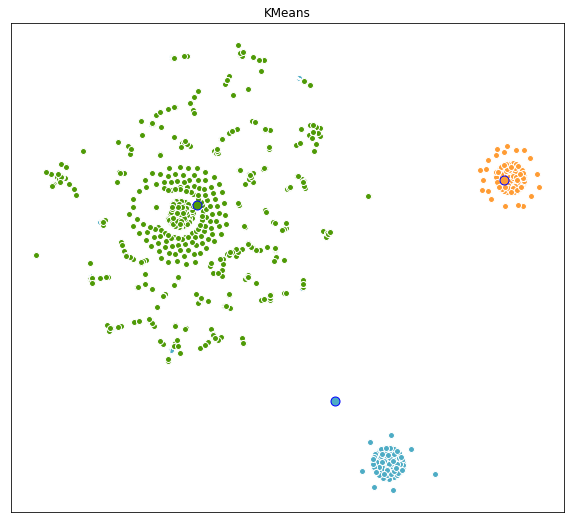

In [34]:
# #############################################################################
# Plot result using TSNE
import numpy

fig = plt.figure(figsize=(8, 8))
fig.subplots_adjust(left=0.02, right=0.98, bottom=0.05, top=0.9)
colors = ["#4EACC5", "#FF9C34", "#4E9A06"]

# KMeans
ax = fig.add_subplot()
for k, col in zip(range(3), colors):
    my_members = y_tsne == k
    cluster_center = numpy.mean(X_tsne[my_members], axis=0)
    ax.plot(X_tsne[my_members, 0], X_tsne[my_members, 1], "w", markerfacecolor=col, marker="o",
           markersize=6)
for k, col in zip(range(3), colors):
    my_members = y_tsne == k
    cluster_center = numpy.mean(X_tsne[my_members], axis=0)
    ax.plot(
        cluster_center[0],
        cluster_center[1],
        "o",
        markerfacecolor=col,
        markeredgecolor="b",
        markersize=9,
    )
ax.set_title("KMeans")
ax.set_xticks(())
ax.set_yticks(())

# ETAP 2: KLASYCZNY ML

## Budowa i ewaluacja modelu

Do analizy sentymentu wykorzystamy 3 klasyczne modele ML:

* Decision Trees
* Nearest Neighbors
* LinearSVC

In [26]:
# !conda install seaborn -y
# !conda install -c conda-forge wordcloud -y
import pickle

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import confusion_matrix, classification_report
# wizualizacja
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [36]:
LOAD_DATA_ETAP_2 = False

if LOAD_DATA_ETAP_2:
    with open('inputs.pkl', 'rb') as f:
       X_train_vec, kmeans_clusters = pickle.load(f)

In [71]:
X_in = X_train_vec
y_in = kmeans_clusters

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train,
                                                    test_size = 0.2,
                                                    random_state =42)
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test,
                                                    test_size = 0.5,
                                                    random_state =42)

print(X_train.shape, X_valid.shape, X_test.shape)
print(y_train.shape, y_valid.shape, y_test.shape)

(44617, 8081) (5577, 8081) (5578, 8081)
(44617,) (5577,) (5578,)


In [38]:
with open('inputs.pkl', 'wb') as f:
    pickle.dump([X_in, y_in], f)

In [39]:
def multiclass_roc(clf):
    # multi-class classification
    from sklearn.multiclass import OneVsRestClassifier
    from sklearn.linear_model import LogisticRegression
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import roc_curve
    from sklearn.metrics import roc_auc_score

    # fit model
    clf = OneVsRestClassifier(clf)
    clf.fit(X_train, y_train)
    print("Fitted")
    pred = clf.predict(X_test)
    if hasattr(clf, 'predict_proba'):
        pred_prob = clf.predict_proba(X_test)
    else:
        pred_prob = clf.decision_function(X_test)
    print("Predicted")
    
    print(X_test.shape, pred_prob.shape)
    # roc curve for classes
    fpr = {}
    tpr = {}
    thresh ={}

    for i in range(NUM_CLUSTERS):
        # [pred_prob[:, i] != nan]
        non_nan_idxs = ~numpy.isnan(pred_prob[:, i])
        fpr[i], tpr[i], thresh[i] = roc_curve(y_test[non_nan_idxs],
                                              pred_prob[:,i][non_nan_idxs],
                                              pos_label=i)

    # plotting    
    plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Class 0 vs Rest')
    plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class 1 vs Rest')
    plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class 2 vs Rest')
    plt.title('Multiclass ROC curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive rate')
    plt.legend(loc='best')
    plt.savefig('Multiclass ROC',dpi=300)
    return pred

def print_confusion_matrix(y_test, y_pred):

  # Wyświetlenie metryk ewaluacji na podstawie predykcji i ground truth (faktycznych etykiet)
  print(classification_report(y_test, y_pred))

  # Obliczamy i wyświetlamy confusion matrix
  cf_matrix = confusion_matrix(y_test, y_pred)
  categories = ['Negative','Positive', 'Neutral']
  group_names = ['True Neg','False Pos', 'False Neg','True Pos']
  group_percentages = ['{0}'.format(value) for value in cf_matrix.flatten()]
  labels = [f'{v1}' for v1 in group_percentages]
  labels = np.asarray(labels).reshape(3, 3)
  sns.heatmap(cf_matrix, annot = labels, cmap = 'Oranges',fmt = '', xticklabels = categories, yticklabels = categories)
  plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
  plt.ylabel("Actual values" , fontdict = {'size':14}, labelpad = 10)
  plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

### Decision Trees

Fitted
Predicted
(4722, 6886) (4722, 3)


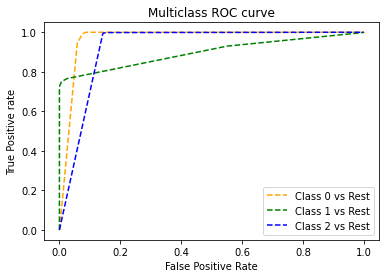

In [37]:
from sklearn.tree import DecisionTreeClassifier
decision_tree = DecisionTreeClassifier(random_state=0, max_depth=5)
y_pred_tree = multiclass_roc(decision_tree)

              precision    recall  f1-score   support

           0       0.67      0.95      0.79       554
           1       0.99      0.77      0.86      3540
           2       0.52      0.99      0.68       628

    accuracy                           0.82      4722
   macro avg       0.73      0.90      0.78      4722
weighted avg       0.89      0.82      0.83      4722



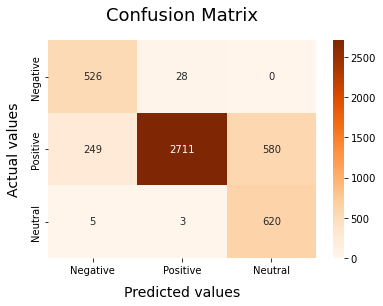

In [38]:
print_confusion_matrix(y_test, y_pred_tree)

### Nearest Neighbors

/home/beniamin/miniconda3/envs/zum/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/home/beniamin/miniconda3/envs/zum/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "
/home/beniamin/miniconda3/envs/zum/lib/python3.8/site-packages/sklearn/neighbors/_base.py:415: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "


Fitted
Predicted
(4722, 6886) (4722, 3)


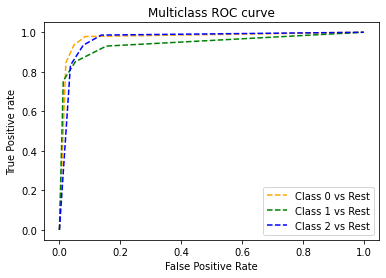

In [39]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=3, algorithm='kd_tree', n_jobs=-1)
y_pred_neigh = multiclass_roc(neigh)

              precision    recall  f1-score   support

           0       0.72      0.94      0.82       554
           1       0.98      0.85      0.91      3540
           2       0.63      0.94      0.76       628

    accuracy                           0.87      4722
   macro avg       0.78      0.91      0.83      4722
weighted avg       0.90      0.87      0.88      4722



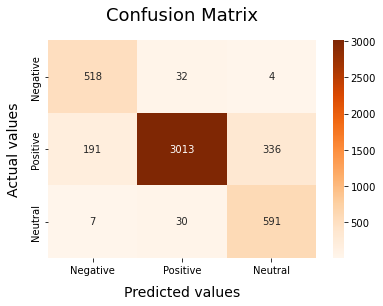

In [40]:
print_confusion_matrix(y_test, y_pred_neigh)

### Naive Bayes

Fitted


/home/beniamin/miniconda3/envs/zum/lib/python3.8/site-packages/sklearn/multiclass.py:382: RuntimeWarning: invalid value encountered in true_divide
  Y /= np.sum(Y, axis=1)[:, np.newaxis]


Predicted
(4722, 6886) (4722, 3)


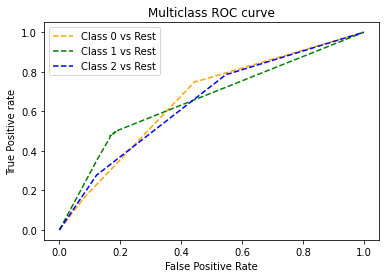

In [41]:
from sklearn.naive_bayes import GaussianNB

X_train_old = X_train
X_test_old = X_test
X_train = X_train.todense()
X_test = X_test.todense()
gnb = GaussianNB()
y_pred_nb = multiclass_roc(gnb)
X_train = X_train_old
X_test = X_test_old

              precision    recall  f1-score   support

           0       0.21      0.16      0.18       554
           1       0.89      0.37      0.53      3540
           2       0.18      0.79      0.29       628

    accuracy                           0.40      4722
   macro avg       0.43      0.44      0.33      4722
weighted avg       0.72      0.40      0.45      4722



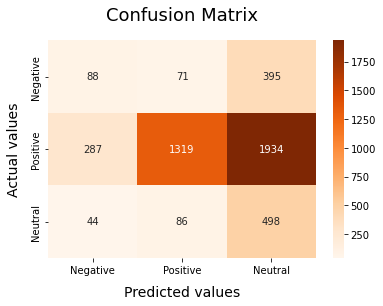

In [42]:
print_confusion_matrix(y_test, y_pred_nb)

### Linear SVC

[LibLinear]

/home/beniamin/miniconda3/envs/zum/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[LibLinear]

/home/beniamin/miniconda3/envs/zum/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[LibLinear]

/home/beniamin/miniconda3/envs/zum/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Fitted
Predicted
(4722, 6886) (4722, 3)


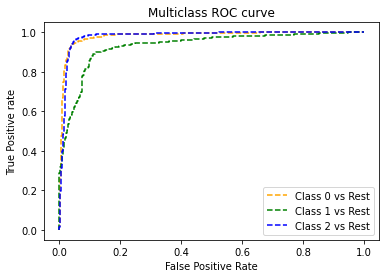

In [43]:
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# Changing from the sparse matrix to the dense one because of the LinearSVC restrictions
X_train_old = X_train
X_test_old = X_test
X_train = X_train.todense()
X_test = X_test.todense()
linear_svc = make_pipeline(StandardScaler(), LinearSVC(random_state=0, tol=1e-5, verbose=1))
y_pred_svc = multiclass_roc(linear_svc)
X_train = X_train_old
X_test = X_test_old

              precision    recall  f1-score   support

           0       0.78      0.94      0.86       554
           1       0.97      0.92      0.95      3540
           2       0.81      0.86      0.83       628

    accuracy                           0.92      4722
   macro avg       0.85      0.91      0.88      4722
weighted avg       0.92      0.92      0.92      4722



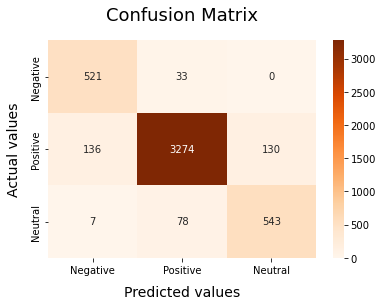

In [44]:
print_confusion_matrix(y_test, y_pred_svc)

# ETAP 3: MODEL NN

In [40]:
def reset_X_y():
    X_train, X_test, y_train, y_test = train_test_split(X_in, y_in,
                                                    test_size = 0.2,
                                                    random_state =42)
    X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test,
                                                        test_size = 0.5,
                                                        random_state =42)
    print(X_train.shape, X_valid.shape, X_test.shape)
    print(y_train.shape, y_valid.shape, y_test.shape)
    
    return (X_train, X_valid, X_test), (y_train, y_valid, y_test)

def prepare(ds, shuffle=False, augment=False, batch_size=64):
    AUTOTUNE = tf.data.AUTOTUNE

    if shuffle:
        ds = ds.shuffle(10, reshuffle_each_iteration=True)
    # Batch all datasets.
    ds = ds.batch(batch_size)
    
    # Use data augmentation only on the training set.
    
    if augment:
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y),
                    num_parallel_calls=AUTOTUNE)
    
    # Use buffered prefetching on all datasets.
    return ds.prefetch(buffer_size=AUTOTUNE)

def test_model(test_model, batch_size=64, verbose=0, modify_ds_func=None, augment=False,
              in_type='float32'):
    
    (X_train, X_valid, X_test), (y_train, y_valid, y_test) = reset_X_y()
    
    X_train = X_train.astype(in_type).toarray()
    X_test = X_test.astype(in_type).toarray()
    X_valid = X_valid.astype(in_type).toarray()
    
    train_dataset = prepare(tf.data.Dataset.from_tensor_slices((X_train, y_train)), True, augment, batch_size)
    valid_dataset = tf.data.Dataset.from_tensor_slices((X_valid, y_valid)).batch(batch_size)
    test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(batch_size)
    
    if modify_ds_func:
        train_dataset, valid_dataset, test_dataset = modify_ds_func(train_dataset, valid_dataset, test_dataset)

    test_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

    history = test_model.fit(train_dataset, epochs=200,
                    batch_size=batch_size, validation_data=valid_dataset,
                    verbose=verbose, callbacks=[early_stopping])
    
    loss, accuracy = test_model.evaluate(test_dataset)
    
    return history, loss, accuracy

def display_result(result, name=None):
    history, loss, accuracy = result
    print(f"Evaluation results:")
    print(f"Loss: {loss:.4}")
    print(f"Accuracy: {accuracy:.2%}")    
    print(f'Num epoches: {len(history.epoch)}')
    print(f'Num parameters: {history.model.count_params()}')
    
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([0, 1])
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.ylim([0, 2])
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()


## Simple NN implementation - z BoW

In [56]:
!pip install numba
from numba import cuda 
device = cuda.get_current_device()
device.reset()

     |████████████████████████████████| 3.4 MB 2.4 MB/s eta 0:00:01
     |████████████████████████████████| 34.5 MB 30.0 MB/s eta 0:00:01


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                112272    
                                                                 
 dense_1 (Dense)             (None, 3)                 51        
                                                                 
Total params: 112,323
Trainable params: 112,323
Non-trainable params: 0
_________________________________________________________________
(38461, 7016) (4808, 7016) (4808, 7016)
(38461,) (4808,) (4808,)
Epoch 1/200
601/601 [==============================] - 8s 13ms/step - loss: 0.4346 - accuracy: 0.8824 - val_loss: 0.1173 - val_accuracy: 0.9834
Epoch 2/200
601/601 [==============================] - 7s 12ms/step - loss: 0.0543 - accuracy: 0.9943 - val_loss: 0.0463 - val_accuracy: 0.9898
Epoch 3/200
601/601 [=====

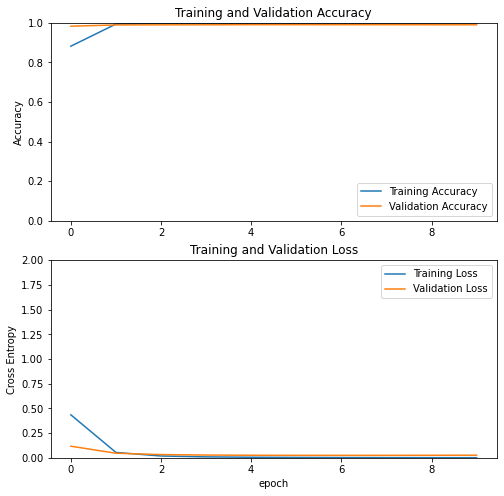

In [41]:
import tensorflow as tf

print(tf.config.list_physical_devices('GPU'))

tf.config.run_functions_eagerly(True)

input_shape = X_train.shape[1:]

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(16, activation='relu',input_shape = input_shape),
    tf.keras.layers.Dense(3)
])

model.summary()

result = test_model(model, verbose=1, batch_size=64)
display_result(result)

# Simple RNN - wektoryzacja 

Nie opłaca się robić Dropoutu, bo macierz wejściowa jest bardzo rzadka, ale zmienimy sposób wektoryzacji z Bag of Words na ciąg embeddingów i zobaczymy ile początkowych tokenów wystarczy, żeby osiągnąć > 95%

In [ ]:
VOCAB_SIZE = 1000

tf.data.experimental.enable_debug_mode()

encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(list(X))
batch_size = 64

model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=48,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(48)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(3)
])

def Xs(x1, x2, x3):
    X_train, X_test, y_train, y_test = train_test_split(X, y_in,
                                                    test_size = 0.2,
                                                    random_state =42)
    X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test,
                                                    test_size = 0.5,
                                                    random_state =42)
    train_dataset = prepare(tf.data.Dataset.from_tensor_slices((X_train, y_train)), True, False, batch_size)
    valid_dataset = tf.data.Dataset.from_tensor_slices((X_valid, y_valid)).batch(batch_size)
    test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(batch_size)
    
    return train_dataset, valid_dataset, test_dataset

model.summary()

result = test_model(model, verbose=1, batch_size=batch_size, modify_ds_func=Xs)
display_result(result)

(38461, 7016) (4808, 7016) (4808, 7016)
(38461,) (4808,) (4808,)
Epoch 1/200
601/601 [==============================] - 39s 65ms/step - loss: 0.1796 - accuracy: 0.9419 - val_loss: 0.0320 - val_accuracy: 0.9896
Epoch 2/200
601/601 [==============================] - 38s 63ms/step - loss: 0.0183 - accuracy: 0.9945 - val_loss: 0.0219 - val_accuracy: 0.9936
Epoch 3/200
601/601 [==============================] - 37s 62ms/step - loss: 0.0141 - accuracy: 0.9956 - val_loss: 0.0278 - val_accuracy: 0.9921
Epoch 4/200
601/601 [==============================] - 36s 61ms/step - loss: 0.0119 - accuracy: 0.9958 - val_loss: 0.0171 - val_accuracy: 0.9944
Epoch 5/200
601/601 [==============================] - 36s 60ms/step - loss: 0.0091 - accuracy: 0.9970 - val_loss: 0.0239 - val_accuracy: 0.9923
Epoch 6/200
601/601 [==============================] - 37s 61ms/step - loss: 0.0070 - accuracy: 0.9976 - val_loss: 0.0229 - val_accuracy: 0.9929
Epoch 7/200
76/76 [==============================] - 2s 27ms/step

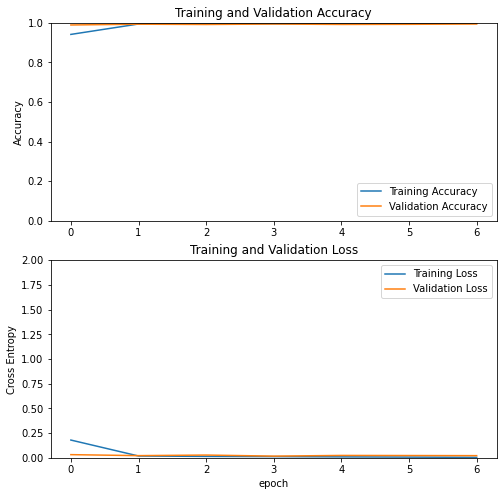

In [104]:
result = test_model(model, verbose=1, batch_size=batch_size, modify_ds_func=Xs)
display_result(result)

# ETAP 4: MODEL OPARTY O MODEL JĘZYKOWY

### BERT

In [1]:
# ! conda install pytorch torchvision torchaudio cudatoolkit=11.3 -c pytorch -y

import torch
from sklearn.model_selection import train_test_split
from transformers import *
from torch.nn import Linear
import numpy as np
import pandas as pd
import pickle


model = BertForSequenceClassification.from_pretrained(
    "dkleczek/bert-base-polish-uncased-v1",
#      config=PretrainedConfig(num_labels=3)
)
tokenizer = BertTokenizer.from_pretrained("dkleczek/bert-base-polish-uncased-v1")

Some weights of the model checkpoint at dkleczek/bert-base-polish-uncased-v1 were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassificatio

In [2]:
#Zamieniłem ostatnią warstwę na output=3
model.classifier = Linear(in_features=768, out_features=3, bias=True)
model.config.num_labels=3

print(model)

inputs = tokenizer("Hello, my dog is cute", return_tensors="pt")
outputs = model(**inputs)
print(outputs)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(60000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [3]:
# %rm X_string X_strings

def save_dataset(Xs, ys):
    with open('X_string', 'wb') as f:
        pickle.dump(Xs, f)
    np.save('y_in', ys)
    
# save_dataset(list(clean_data.text.map(str)), kmeans_clusters)

with open('X_string', 'rb') as f:
    X = pd.Series(pickle.load(f))
    
y_in = np.load('y_in.npy')

X_train, X_test, y_train, y_test = train_test_split(X, y_in,
                                                test_size = 0.2,
                                                random_state =42)
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test,
                                                    test_size = 0.5,
                                                    random_state =42)
print(X_train.shape, X_valid.shape, X_test.shape)
print(y_train.shape, y_valid.shape, y_test.shape)

(46147,) (5768,) (5769,)
(46147,) (5768,) (5769,)


In [4]:
# Preprocess

text_test = list(X[:1])
text_preprocessed = tokenizer(text_test)
print(text_test)
print(text_preprocessed)
# print(tokenizer.decode(text_preprocessed["input_ids"][0]))
print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {len(text_preprocessed["input_ids"])}')
print(f'Word Ids   : {text_preprocessed["input_ids"]}')
print(f'Input Mask : {text_preprocessed["attention_mask"]}')
print(f'Type Ids   : {text_preprocessed["token_type_ids"]}')

['bz sonko']
{'input_ids': [[2, 42214, 7048, 1929, 4]], 'token_type_ids': [[0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1]]}
Keys       : ['input_ids', 'token_type_ids', 'attention_mask']
Shape      : 1
Word Ids   : [[2, 42214, 7048, 1929, 4]]
Input Mask : [[1, 1, 1, 1, 1]]
Type Ids   : [[0, 0, 0, 0, 0]]


In [5]:
from datasets import load_dataset

from datasets import Dataset, DatasetDict

DATA_COLUMN = "X"
LABEL_COLUMN = "labels"
train = pd.DataFrame({DATA_COLUMN: X_train, LABEL_COLUMN: y_train})
test = pd.DataFrame({DATA_COLUMN: X_test, LABEL_COLUMN: y_test})

dataset_train = Dataset.from_pandas(train)
dataset_test = Dataset.from_pandas(test)

from datasets import Dataset
raw_datasets = DatasetDict({
    'train': dataset_train,
    'test': dataset_test
})

def tokenize_function(examples):
    return tokenizer(examples["X"], max_length=19, padding='max_length', truncation=True)

tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)

small_train_dataset = tokenized_datasets["train"].shuffle(seed=42).select(range(1000)) 
small_eval_dataset = tokenized_datasets["test"].shuffle(seed=42).select(range(1000))
full_train_dataset = tokenized_datasets["train"]
full_eval_dataset = tokenized_datasets["test"]

  0%|          | 0/47 [00:00<?, ?ba/s]

  0%|          | 0/6 [00:00<?, ?ba/s]

In [6]:
len(small_train_dataset['input_ids'][0])
dataset_train['X']

['najpierw europie zachodniej błagają pomoc pracowników zbiorach prawdziwa weryfikacja intencji przychodzi zapewnić godne warunki ciekawy wątek gastarbeiterach rumuńskich niemczech sqnwfsbar',
 'icymi ⬇ ️',
 'pad podpisze mld tvp nikt zauważy coronavirus',
 'poseł edward siarka solidarna polska parlamentarzysta podsarnia pierwszą osobą zakażoną koronawirusem terenu podhala covi',
 'the latest rynki zagraniczne wiadomości informacje aktualności sz coronavirus environment',
 'serio rekord normalny sarscov covi',
 'liczba zakażeń koronawirus sarscov covi izrael sięgnęła pierwszy zgon hawaje honolulu link stcolhjtezo',
 'liczba wniosków świadczenia bezrobotnych holandia marcu zwiększyła proc pandemia koronawirus sarscov covi',
 'dopiero zdjęcie gaci ameryce całym światem mocarstwo bierze respiratory ruskiej firmy którą samo założyło sankcje putin mistrzem zagraniach ująć',
 'tymczasem chinach dyskryminacja rasizm chińczyków',
 'informujemy wykonujemy badań wykrycia koronawirusa covi wytycz

In [7]:
from transformers import Trainer
from transformers import TrainingArguments

training_args = TrainingArguments("bert_trainer",
                                  per_device_train_batch_size = 64,
                                  per_device_eval_batch_size = 8,
                                  num_train_epochs = 15)
import os
import torch
torch.cuda.empty_cache()

os.environ["CUDA_LAUNCH_BLOCKING"]="1"
import numpy as np
from datasets import load_metric

metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    print(eval_pred)
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

# device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

from torch import nn
from transformers import Trainer

class SparseMulticlassTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        del inputs['labels']
        import torch.nn.functional as F
        labels = F.one_hot(labels)
        outputs = model(**inputs)
        logits = outputs.get('logits')
        loss_fct = nn.CrossEntropyLoss()
        loss = loss_fct(logits.view(-1, self.model.config.num_labels),
                        labels.float().view(-1, self.model.config.num_labels))
        return (loss, outputs) if return_outputs else loss
    
trainer.place_model_on_device=False
trainer = SparseMulticlassTrainer(
    model=model,
    args=training_args,
    train_dataset=full_train_dataset,
    eval_dataset=full_eval_dataset,
    compute_metrics=compute_metrics

)
trainer.train()

trainer.evaluate()

The following columns in the training set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: X, __index_level_0__.
***** Running training *****
  Num examples = 46147
  Num Epochs = 15
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Total optimization steps = 10830


Step,Training Loss
500,0.302200
1000,0.219000
1500,0.196700
2000,0.132900
2500,0.084200
3000,0.059900
3500,0.036400
4000,0.024800
4500,0.022800
5000,0.018900


Saving model checkpoint to bert_trainer/checkpoint-500
Configuration saved in bert_trainer/checkpoint-500/config.json
Model weights saved in bert_trainer/checkpoint-500/pytorch_model.bin
Saving model checkpoint to bert_trainer/checkpoint-1000
Configuration saved in bert_trainer/checkpoint-1000/config.json
Model weights saved in bert_trainer/checkpoint-1000/pytorch_model.bin
Saving model checkpoint to bert_trainer/checkpoint-1500
Configuration saved in bert_trainer/checkpoint-1500/config.json
Model weights saved in bert_trainer/checkpoint-1500/pytorch_model.bin
Saving model checkpoint to bert_trainer/checkpoint-2000
Configuration saved in bert_trainer/checkpoint-2000/config.json
Model weights saved in bert_trainer/checkpoint-2000/pytorch_model.bin
Saving model checkpoint to bert_trainer/checkpoint-2500
Configuration saved in bert_trainer/checkpoint-2500/config.json
Model weights saved in bert_trainer/checkpoint-2500/pytorch_model.bin
Saving model checkpoint to bert_trainer/checkpoint-30

EvalPrediction(predictions=array([[-4.109118 , -3.9056966,  8.201502 ],
       [-3.5443218,  7.9658422, -3.190454 ],
       [-3.7093608, -4.215397 ,  8.043067 ],
       ...,
       [-4.078949 ,  7.967165 , -2.7274706],
       [-3.9963648, -3.9736624,  8.193542 ],
       [-3.952962 , -3.9761953,  8.178598 ]], dtype=float32), label_ids=array([2, 1, 2, ..., 1, 2, 2]))


{'eval_loss': 0.9045138955116272,
 'eval_accuracy': 0.9008493673080257,
 'eval_runtime': 16.7604,
 'eval_samples_per_second': 344.203,
 'eval_steps_per_second': 43.078,
 'epoch': 15.0}

# PODSUMOWANIE

## ETAP 1: POZYSKANIE DANYCH

Tweety zostały ściągnięte z Twittera za pomocą biblioteki tweepy - bardzo prosty i wygodny framework. Problemem było to, że jest ograniczona liczba Tweetów, które można ściągać jednocześnie, więc trwało to bardzo długo.

Ponieważ Tweety były dostępne zarówno tutaj, jak i w procesie ściągającym - użyłem bazy danych in-memory (Redis) w celu ich persystencji.

Następnie zrobiłem preprocessing danych:
* Normalizacja do małych liter
* Usuwanie URL, hashtagów
* Usuwanie znaków interpunkcyjnych
* Usuwanie stopwordsów
* Usuwanie powtarzających się znaków
* Usuwanie znaków numerycznych
* Tokenizacja TweetTokenizerem

Następnie stworzyłem word-embedding używając TfIdfVectorizera i podzieliłem Tweety na 3 grupy używając K-Means.

Ręcznie przeczyściłem kilka sentencji, kilka tweetów usunąłem i doszedłem do wniosku, że grupa:
```
0 - tweety względnie neutralne
2 - tweety negatynwe
1 - tweety pozytywne, zagrzewające do walki, mówiące, że będzie OK
```
Przy użyciu TSNE pokazałem rozkład Tweetów - bardzo zaszumione.

## ETAP 2: KLASYCZNY ML

Wybrałem 3 modele:

* Drzewo decyzyjne

```
              precision    recall  f1-score
    accuracy                           0.82
   macro avg       0.73      0.89      0.78
weighted avg       0.88      0.82      0.83


```

* K-najbliższych sąsiadów

```
              precision    recall  f1-score
    accuracy                           0.85
   macro avg       0.76      0.90      0.81
weighted avg       0.89      0.85      0.86


```

* Naive Bayes

```
              precision    recall  f1-score
    accuracy                           0.40
   macro avg       0.42      0.47      0.34
weighted avg       0.72      0.40      0.46


```

* Linear SVC

```
              precision    recall  f1-score
    accuracy                           0.91
   macro avg       0.84      0.90      0.86
weighted avg       0.92      0.91      0.91


```


Drzewo deyczyjne wypadło najlepiej, co pokazuje, że K-MEANS można było zamodelować prostymi regułami drzewa decyzyjnego, jednak przy zmniejszeniu liczby cech - model zaczyna działać coraz gorzej. Po prostu zapewne model wybiera najmniej liczne klasy i uczy się je rozróżniać.

Model KNN - działa lepiej niż losowo, zasadniczo wręcz całkiem dobrze.

Linear SVC działa tak, że puszczam jednego dnia - a po pracy sprawdzam wyniki - działa to strasznie wolno, ale wyniki są całkiem dobre. Aż przyszeðł moment, kiedy liczba cech była zbyt duża i po prostu model ten przestał działać ze względu na znaczną objętość danych wejściowych.

Zamiast tego użyłem zatem Nauve Bayesa, gdzie wyniki również nie były powalające.

## ETAP 3: MODEL NN

Mogel działający w oparciu o Bag of Words ma znakomite wyniki - w zasadzie już od pierwszej epoki wyniki są prawie 100%.

Na zbiorze walidacyjnym wyniki są równie dobre.
```
Trainable params: 112,323

Accuracy: 98.96%
Num epoches: 10
```

Następnie starałem się uzyskać podobny wynik dla innego rodzaju wektoryzacji - tym razem po prostu dla zrobienia embeddingów dla sekwencji wejściowej.

```
Trainable params: 91,651

Accuracy: 99.40%
Num epoches: 7
```

## ETAP 4: MODEL OPARTY O MODEL JĘZYKOWY BERT

Na koniec spróbowałem wytrenować model BERT (Bidirectional Encoder Representations) dla dancyh wejściowych. Do tego celu użyłem modelu wytrenowanego przez `huggingface` [model](https://huggingface.co/dkleczek/bert-base-polish-uncased-v1).
Następnie należało w tym modelu podmienić liczbę zmiennych wyjściowych z 2 na 3 (myślę, że jest na to łatwiejsze rozwiązanie, niż dobieranie się do parametrów klasy `nn.Module`).

Następnie dokonałem fine-tuningu tego modelu i uzyskałem następujące wyniki:
    
```
'eval_loss': 0.422034472m22709656
'eval_accuracy': 90.34%
'eval_samples_per_second': 350.111
'eval_steps_per_second': 43.817
'epoch': 3.0
```

Zapisane modele są dostępne w folderze `bert_trainer`.


Po 15 epokach treningu model nie poprawia wyniku:
```
eval_loss': 0.9045138955116272
eval_accuracy': 0.9008493673080257
eval_runtime': 16.7604
eval_samples_per_second': 344.203
eval_steps_per_second': 43.078
epoch': 15.0
```